
# LoRaSim2: simulate collisions in LoRa
Extension to the original LoRaSim by Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

In [13]:
# import modules
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

## Hardware Sensitivity

Modelling the changes in receiver sensitivity with changes in bandwidth and spreading factor.

These values are derived from Utz's experiments

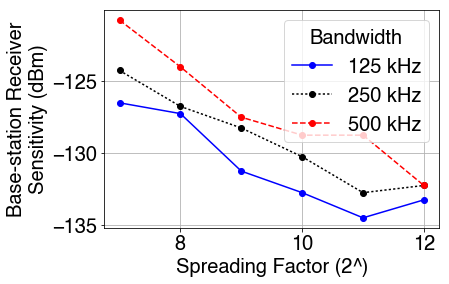

In [17]:
# this is an array with measured values for sensitivity
# see LoRa scaling paper, Table 1
sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

# array of sensitivity values
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])

# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()
    
plotSensitivity(sensi)

## Packet Airtime

Packets of the same size can have varying airtime due to choices of spreading factors and coding rates. The preamble must also be a part of each packet which also adds to the airtime.

The actual formulas cann be seen in the LoRa Design Guide document

**TODO: Add direct formulae from the document**

In [5]:
# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

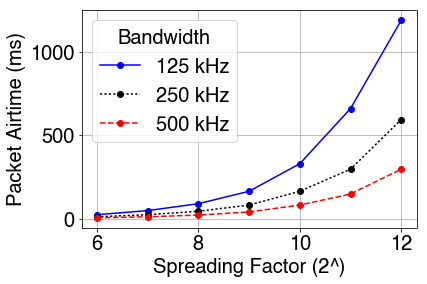

In [21]:
def plotAirtime():
    
    cr = 4/5 # fixed coding rate
    pl = 20 # fixed payload length in bytes
    
    bw_list = [125, 250, 500]
    sf_list = [6, 7, 8, 9, 10, 11, 12]
    
    time_in_air = np.zeros((len(bw_list), len(sf_list)))
    
    for i,bw in enumerate(bw_list):
        for j,sf in enumerate(sf_list):
            time_in_air[i,j] = airtime(sf, cr, pl, bw)
            
    airtime_fig = plt.figure()
    
    at125, = plt.plot(sf_list, time_in_air[0,:], "bo-", label="125 kHz")
    at250, = plt.plot(sf_list, time_in_air[1,:], "ko:", label="250 kHz")
    at500, = plt.plot(sf_list, time_in_air[2,:], "ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [at125, at250, at500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Packet Airtime (ms)")

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    
    plt.show()
    
plotAirtime()

## Packet Collisions

A number of things determine if 2 or more packets would collide in the air: overlapping spectrum of transmissions, spreading factor leakages, timing collisions etc.

The traditional method of modelling this is using the independent interference model, which checks for the interference between any two packets currently in the air (and not more). This is the method currently used by the original LoRaSim.

Another method is the more complex additive interference model. The next few section will test both of these

In [23]:
# collision checks using the independent interference model
# the collision functions are heavily dependent on the object definitions

# log shadow model parameters
Ptx = 14
gamma = 2.08
d0 = 40.0
var = 0           # variance ignored for now
Lpld0 = 127.41
GL = 0

full_collision = True

#
# check for collisions at base station
# Note: called before a packet (or rather node) is inserted into the list
#
# conditions for collions:
#     1. same sf
#     2. frequency, see function below (Martins email, not implementet yet):
def checkcollision(packet):
    col = 0 # flag needed since there might be several collisions for packet
    # lost packets don't collide
    if packet.lost:
       return 0
    if packetsAtBS[packet.bs]:
        for other in packetsAtBS[packet.bs]:
            if other.id != packet.nodeid:
               # simple collision
               if frequencyCollision(packet, other.packet[packet.bs]) \
                   and sfCollision(packet, other.packet[packet.bs]):
                   if full_collision:
                       if timingCollision(packet, other.packet[packet.bs]):
                           # check who collides in the power domain
                           c = powerCollision(packet, other.packet[packet.bs])
                           # mark all the collided packets
                           # either this one, the other one, or both
                           for p in c:
                               p.collided = 1
                       else:
                           # no timing collision, all fine
                           pass
                   else:
                       packet.collided = 1
                       other.packet[packet.bs].collided = 1  # other also got lost, if it wasn't lost already
                       col = 1
        return col
    return 0

#
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
    if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
        return True
    elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
        return True
    else:
        if (abs(p1.freq-p2.freq)<=30):
            return True
    return False

def sfCollision(p1, p2):
    if p1.sf == p2.sf:
        # p2 may have been lost too, will be marked by other checks
        return True
    return False

def powerCollision(p1, p2):
    powerThreshold = 6 # dB
    if abs(p1.rssi - p2.rssi) < powerThreshold:
        # packets are too close to each other, both collide
        # return both packets as casualties
        return (p1, p2)
    elif p1.rssi - p2.rssi < powerThreshold:
        # p2 overpowered p1, return p1 as casualty
        return (p1,)
    # p2 was the weaker packet, return it as a casualty
    return (p2,)

def timingCollision(p1, p2):
    # assuming p1 is the freshly arrived packet and this is the last check
    # we've already determined that p1 is a weak packet, so the only
    # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

    # assuming 8 preamble symbols
    Npream = 8

    # we can lose at most (Npream - 5) * Tsym of our preamble
    Tpreamb = 2**p1.sf/(1.0*p1.bw) * (Npream - 5)

    # check whether p2 ends in p1's critical section
    p2_end = p2.addTime + p2.rectime
    p1_cs = env.now + Tpreamb
    if p1_cs < p2_end:
        # p1 collided with p2 and lost
        return True
    return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

#
# this function creates a BS
#
class myBS():
    def __init__(self, position, id):
        self.id = id
        self.x, self.y = position

        # This is a hack for now
        global nrBS
        global maxDist
        global maxX
        global maxY

#
# this function creates a node
#
class myNode():
    def __init__(self, id, position, period, packetlen):
        global bs

        self.id = id
        self.period = period
        self.x, self.y = position
        self.packet = []
        self.dist = []
        
        # create "virtual" packet for each BS
        global nrBS
        for i in range(0,nrBS):
            d = np.sqrt((self.x-bs[i].x)*(self.x-bs[i].x)+(self.y-bs[i].y)*(self.y-bs[i].y))
            self.dist.append(d)
            self.packet.append(myPacket(self.id, packetlen, self.dist[i], i))

        self.sent = 0

#
# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket():
    def __init__(self, nodeid, plen, distance, freq, bs, sf, cr, bw):
        global experiment
        global Ptx
        global gamma
        global d0
        global var
        global Lpld0
        global GL


        # new: base station ID
        self.bs = bs
        self.nodeid = nodeid
        
        # randomize configuration values
        self.sf = sf
        self.cr = cr
        self.bw = bw

        # log-shadow
        Lpl = Lpld0 + 10*gamma*math.log(distance/d0)
        print Lpl
        Prx = Ptx - GL - Lpl

        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = plen
        self.symTime = (2.0**self.sf)/self.bw
        self.arriveTime = 0
        self.rssi = Prx
        self.freq = freq

        self.rectime = airtime(self.sf,self.cr,self.pl,self.bw)
        # denote if packet is collided
        self.collided = 0
        self.processed = 0

        global minsensi
        self.lost = self.rssi < sensi[sf-7, int(bw // 250)]
#        print "node {} bs {} lost {}".format(self.nodeid, self.bs, self.lost)


